In [1]:
import sys
sys.path.append("../src/")
sys.path.append("../src/AtomicT")

In [108]:
from AtomicT import elastic
from AtomicT import potentials
from AtomicT import constants
from AtomicT import spinexchange
from AtomicT import dipolelosses
import numpy as np
import pylab as plt
from AtomicT.dipolelosses import DipoleChannels
from AtomicT.spinexchange import SpinExChannels

In [109]:
k_A  = np.array([1e-4])
k_eV = k_A / constants.hcInEVAngstrom

r0       = 1e-9
intlimit = 100 * constants.BohrInAng/constants.hcInEVAngstrom
rhos     = np.linspace(r0, intlimit, 100)

muT = constants.TritiumConstants.mu

even_ls = np.arange(0, 16, 2)  

sigma_T_by_l = {}
sigma_T_total = np.zeros_like(k_A)  

for l in even_ls:
    sigma_T_partial = np.array([
        elastic.GetCrossSection(rhos, k, l, muT,
                                potentials.Silvera_Triplet, 'Radau')
        for k in k_A
    ])
    sigma_T_by_l[l] = sigma_T_partial
    sigma_T_total   += sigma_T_by_l[l]

In [110]:
def total_sigma_for_potential(pot_obj, k_grid_A, rhos, mu, integrator='Radau'):
    sigma_total = np.zeros_like(k_grid_A, dtype=float)
    for l in even_ls:
        
        sigma_l = np.array([elastic.GetCrossSection(rhos, k, l, mu, pot_obj, integrator)
            for k in k_grid_A])
        sigma_total += sigma_l
        
    return sigma_total

sigmaT_raw   = {}
sigmaT_ratio = {}

for pot_key, pot in potentials.Triplets.items():
    sigmaT_raw[pot_key] = total_sigma_for_potential(pot, k_A, rhos, muT)

for pot_key, sig in sigmaT_raw.items():
    sigmaT_ratio[pot_key] = sig / sigma_T_total

In [111]:
print("Elastic shift from discrete triplet")
for pot_key in potentials.Triplets.keys():
    mean_ratio = float(np.mean(sigmaT_ratio[pot_key]))
    std_ratio  = float(np.std(sigmaT_ratio[pot_key]))
    print(f"{pot_key} / Silvera — mean ratio: {mean_ratio:.4f}")
print("    Std: ", np.std([i[0] for i in sigmaT_ratio.values()]))

Elastic shift from discrete triplet
Kolos 74 / Silvera — mean ratio: 1.0270
Silvera / Silvera — mean ratio: 1.0000
Jamieson / Silvera — mean ratio: 1.1463
    Std:  0.06357644552539483


In [112]:
def Potential_Perturbation(R):
    x = R * constants.hcInEVAngstrom / 4.16
    return (1 + .001*x) * potentials.Silvera_Triplet(R)

sigma_T_total_potential_perturb = total_sigma_for_potential(Potential_Perturbation, k_A, rhos, muT)

In [113]:
print("Elastic shift from triplet distortion")
ratio = sigma_T_total_potential_perturb / sigma_T_total
mean_ratio = np.mean(ratio)
std_ratio  = np.std(ratio)

print(f"Mean ratio: {mean_ratio:.4f}")

Elastic shift from triplet distortion
Mean ratio: 1.0403


In [114]:
sigmaT_raw_adiabatic = {}
sigmaT_ratio_adiabatic = {}

for pot_key, pot in potentials.TripletsT.items():
    sigmaT_raw_adiabatic[pot_key] = total_sigma_for_potential(pot, k_A, rhos, muT)

for pot_key in sigmaT_raw_adiabatic:
    sigmaT_ratio_adiabatic[pot_key] = sigmaT_raw_adiabatic[pot_key] / sigmaT_raw[pot_key]

In [115]:
print("Shift from adiabatic correction")
entries=[]
for pot_key, ratio in sigmaT_ratio_adiabatic.items():
    entries.append(np.mean(ratio))
    print(f"{pot_key}: mean = {entries[-1]:.4f}")
print("    Std: ", np.std(entries))


Shift from adiabatic correction
Kolos 74: mean = 1.0381
Silvera: mean = 1.0376
Jamieson: mean = 0.9266
    Std:  0.052452727727862386


In [116]:
extrapolation_potentials = {"Jamieson_Triplet_HFD": potentials.Jamieson_Triplet_HFD,
                            "Jamieson_Triplet_VDW": potentials.Jamieson_Triplet_VDW,}

sigmaT_raw_extrapolation = {}
sigmaT_ratio_extrapolation = {}

for pot_key, pot in extrapolation_potentials.items():
    sigmaT_raw_extrapolation[pot_key] = total_sigma_for_potential(pot, k_A, rhos, muT)

for pot_key, sigma_raw in sigmaT_raw_extrapolation.items():
    sigmaT_ratio_extrapolation[pot_key] = sigma_raw / sigmaT_raw_extrapolation["Jamieson_Triplet_HFD"]

In [117]:

print("Shift from extrapolation")
for pot_key, ratio in sigmaT_ratio_extrapolation.items():
    mean_ratio = np.mean(ratio)
    std_ratio = np.std(ratio)

    print(f"{pot_key}: mean = {mean_ratio:.4f}")

Shift from extrapolation
Jamieson_Triplet_HFD: mean = 1.0000
Jamieson_Triplet_VDW: mean = 1.0103


In [121]:
amuT=3.0155007/3.01604928*constants.TritiumConstants.mu
sigmaT_raw_atomic = total_sigma_for_potential(pot, k_A, rhos, amuT)
sigmaT_ratio_atomic = sigmaT_raw_atomic / sigma_T_total

In [123]:


mean_val = np.mean(sigmaT_ratio_atomic)
print("Shift from non-adiabatic")
print(f"σT_ratio_atomic: mean = {mean_val:.4f}")

Shift from non-adiabatic
σT_ratio_atomic: mean = 1.1519


In [45]:
potT = potentials.Silvera_Triplet

B_values = np.linspace(0.001, 0.1, 10)
T = 5e-4
rhos = np.linspace(1e-9, 0.75, 2000)

G_factors_rawDip = {}
G_factor_ratiosDip = {}

base_key = "Silvera"
base_potential = potentials.Triplets[base_key]


base_losses_by_channel = {}
for c in DipoleChannels:
    base_losses_by_channel[str(c)] = np.array([dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T, base_potential,0,2,-2, rhos)for B in B_values])

In [47]:
for pot_key, pot in potentials.Triplets.items():
    G_factors_rawDip[pot_key] = {}
    G_factor_ratiosDip[pot_key] = {}

    for c in DipoleChannels:
        channel_str = str(c)
        losses = np.array([dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T, pot,0,2,-2, rhos)for B in B_values])
        G_factors_rawDip[pot_key][channel_str] = losses
        G_factor_ratiosDip[pot_key][channel_str] = losses / base_losses_by_channel[channel_str]


=== Kolos 74 / Silvera (Dipole) ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0190
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0172
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 1.0169
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 1.0120
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 1.0097


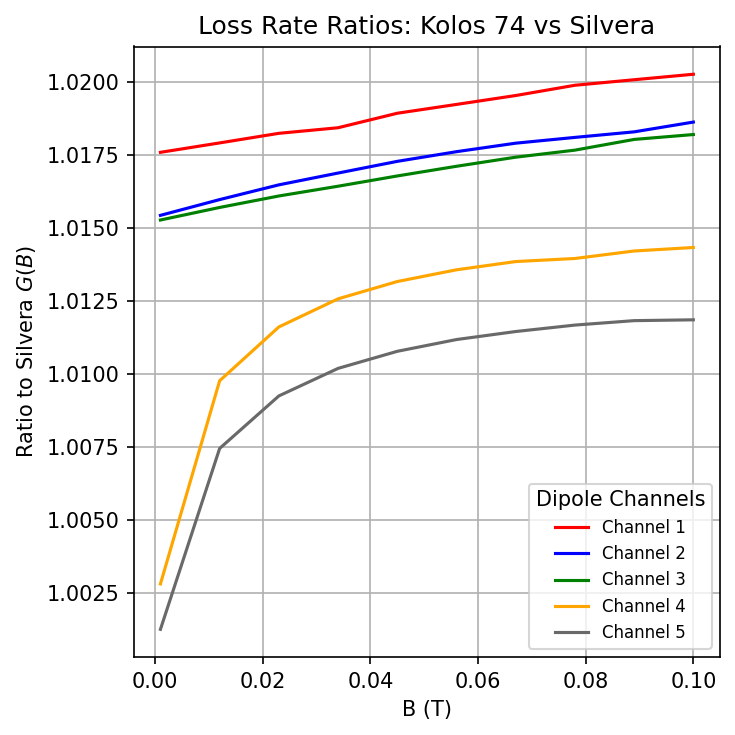


=== Silvera / Silvera (Dipole) ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0000
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0000
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 1.0000
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 1.0000
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 1.0000


/var/folders/x8/m88g9m690wb3gf4t7ds85nzw0000gn/T/ipykernel_31228/1151998355.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Dipole Channels", fontsize=8)


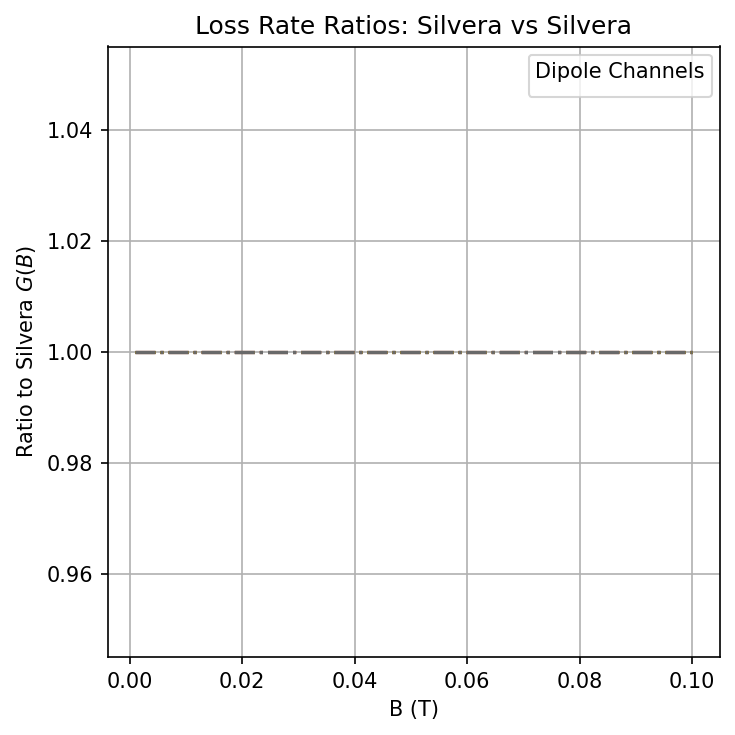


=== Jamieson / Silvera (Dipole) ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0978
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0893
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 1.0873
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 1.0624
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 1.0505


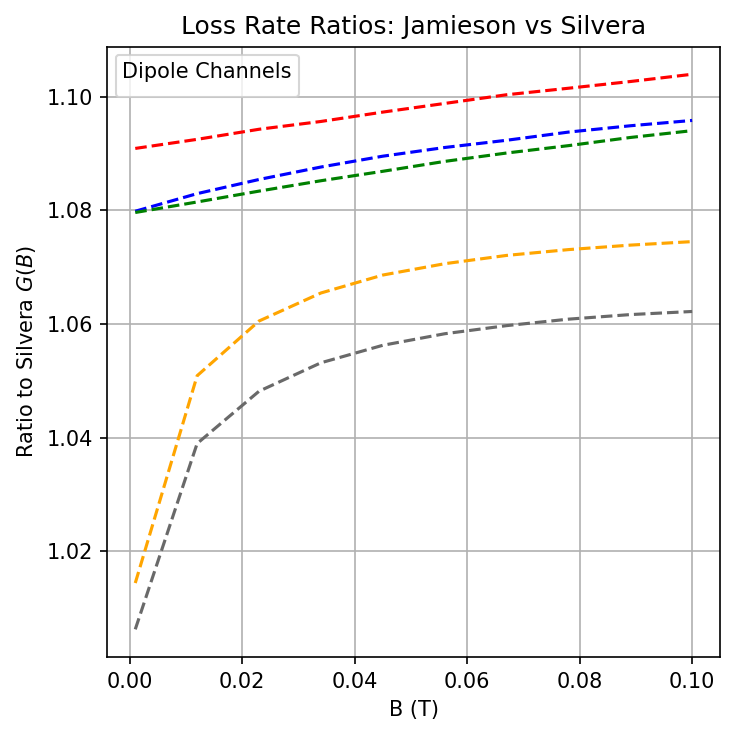

In [56]:
colors = ['red', 'blue', 'green', 'orange', 'dimgrey']
linetypes = ['-', '-.', '--', ':']

for pi, pot_key in enumerate(potentials.Triplets.keys()):
    print(f"\n=== {pot_key} / {base_key} (Dipole) ===")
    plt.figure(figsize=(5, 5), dpi=150)

    c=DipoleChannels[0]
    for ci, c in enumerate(DipoleChannels):
        channel_str = str(c)
        ratios = np.asarray(G_factor_ratiosDip[pot_key][channel_str], dtype=float)
        ratios[~np.isfinite(ratios)] = np.nan

        mean_ratio = np.nanmean(ratios)

        print(f"Channel {ci+1} ({channel_str}): "f"mean = {mean_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None
        plt.plot(B_values,ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)

    plt.xlabel("B (T)")
    plt.ylabel(f"Ratio to {base_key} $G(B)$")
    plt.title(f"Loss Rate Ratios: {pot_key} vs {base_key}")
    plt.grid(True, which='both')
    plt.legend(title="Dipole Channels", fontsize=8)
    plt.tight_layout()
    plt.show()

In [64]:
colors = ['red', 'blue', 'green', 'orange', 'dimgrey']
linetypes = ['-', '-.', '--', ':']

for pi, pot_key in enumerate(potentials.Triplets.keys()):

    c=DipoleChannels[0]
    channel_str = str(c)
    ratios = np.asarray(G_factor_ratiosDip[pot_key][channel_str], dtype=float)
    ratios[~np.isfinite(ratios)] = np.nan
    entries.append(np.nanmean(ratios))

print(f"aa->dd spread due to trip potential: "f"mean = {np.std(entries):.4f}")



aa->dd spread due to trip potential: mean = 0.0471


In [65]:
label = 'Dip_Trip'  
G_factors_raw_perturb   = {label: {}}   
G_factor_ratios_perturb = {label: {}}   

for c in DipoleChannels:
    channel_str = str(c)
    losses = np.asarray([
        dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T,Potential_Perturbation,  lin=0, lout=2,dm=-2,rhos=rhos)
            for B in B_values], dtype=float)

    G_factors_raw_perturb[label][channel_str]   = losses
    G_factor_ratios_perturb[label][channel_str] = losses / base_losses_by_channel[channel_str]



=== Dip_Trip: Potential_Perturbation / Base (Dipole) ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0270, std = 0.0011
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0247, std = 0.0013
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 1.0242, std = 0.0013
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 1.0174, std = 0.0048
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 1.0142, std = 0.0045


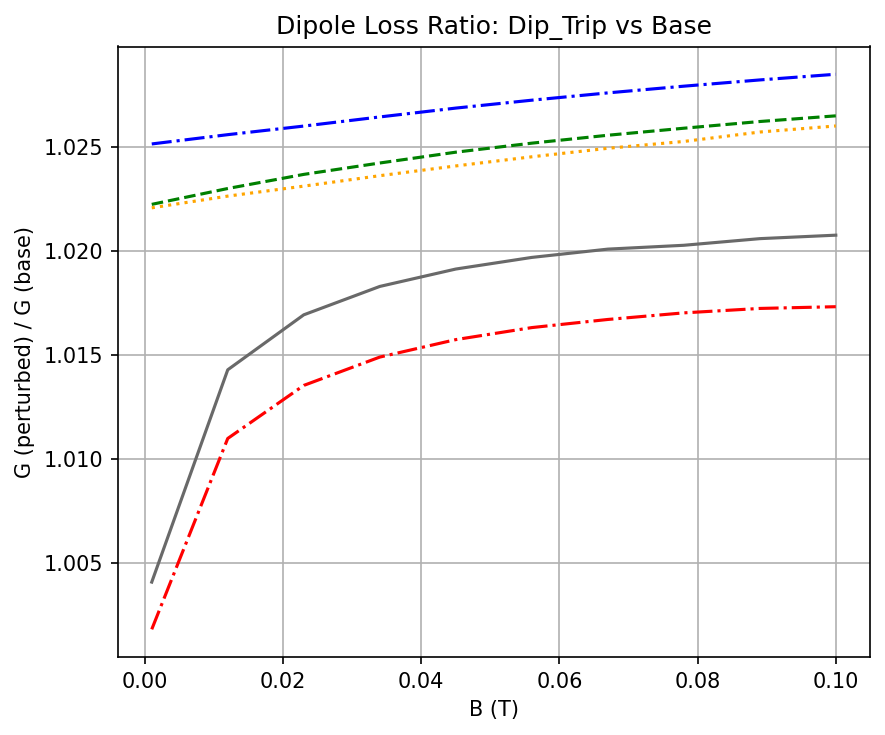

In [66]:
print(f"\n=== {label}: Potential_Perturbation / Base (Dipole) ===")
for i, (channel_str, ratio_obj) in enumerate(G_factor_ratios_perturb[label].items(), start=1):
    ratios = np.asarray(ratio_obj, dtype=float)
    ratios[~np.isfinite(ratios)] = np.nan  

    mean_ratio = np.nanmean(ratios)
    std_ratio  = np.nanstd(ratios)
    print(f"Channel {i} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

plt.figure(figsize=(6,5), dpi=150)
for i, (channel_str, ratio_obj) in enumerate(G_factor_ratios_perturb[label].items(), start=1):
    ratios = np.asarray(ratio_obj, dtype=float)
    ratios[~np.isfinite(ratios)] = np.nan
    plt.plot(
        B_values, ratios,
        linestyle=linetypes[i % len(linetypes)],
        color=colors[i % len(colors)],
        label=f"Channel {channel_str}"
    )

plt.xlabel("B (T)")
plt.ylabel("G (perturbed) / G (base)")
plt.title(f"Dipole Loss Ratio: {label} vs Base")
plt.grid(True, which='both')
#plt.legend(title="Dipole Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [74]:

entries=[]
for pi, pot_key in enumerate(potentials.Triplets.keys()):

    c=DipoleChannels[0]
    channel_str = str(c)
    ratios = np.asarray(G_factor_ratiosDip[pot_key][channel_str], dtype=float)
    ratios[~np.isfinite(ratios)] = np.nan
    entries.append(np.nanmean(ratios))

print(f"aa->dd spread due to trip disortion: "f"mean = {np.std(entries):.4f}")



aa->dd spread due to trip disortion: mean = 0.0423


In [76]:
G_factors_raw_adiabaticDip = {}
G_factor_ratios_adiabaticDip = {}

for pot_key, pot in potentials.TripletsT.items():
    G_factors_raw_adiabaticDip[pot_key] = {}
    G_factor_ratios_adiabaticDip[pot_key] = {}

    for c in DipoleChannels:
        channel_str = str(c)
        losses = np.array([dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T, pot, 0,2,-2,rhos)for B in B_values])
        G_factors_raw_adiabaticDip[pot_key][channel_str] = losses
        G_factor_ratios_adiabaticDip[pot_key][channel_str] = losses / G_factors_rawDip[pot_key][channel_str]


=== Kolos 74 / Silvera (Dipole) ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0256, std = 0.0010
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0234, std = 0.0013
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 1.0230, std = 0.0012
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 1.0165, std = 0.0046
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 1.0135, std = 0.0043


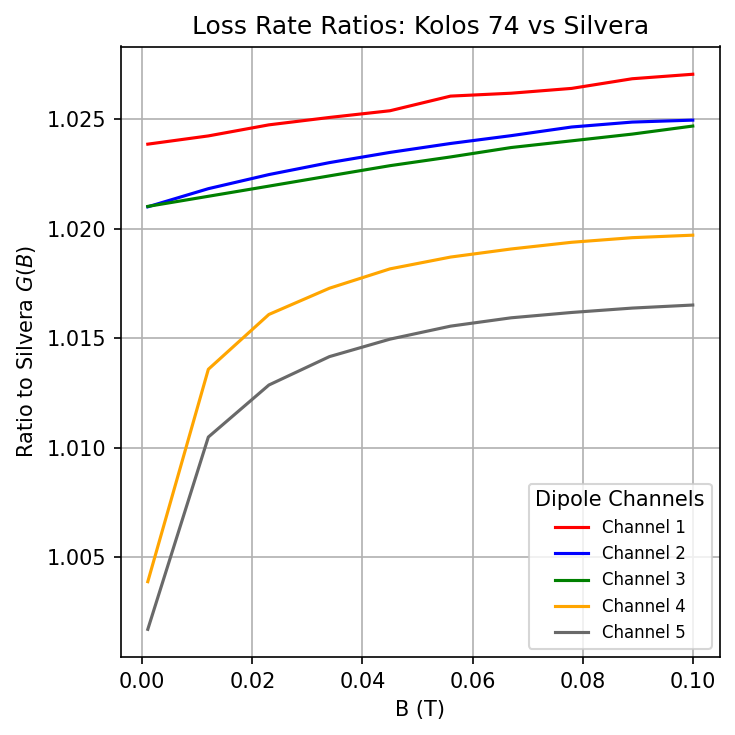


=== Silvera / Silvera (Dipole) ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0252, std = 0.0010
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0231, std = 0.0013
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 1.0227, std = 0.0012
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 1.0163, std = 0.0045
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 1.0132, std = 0.0042


/var/folders/x8/m88g9m690wb3gf4t7ds85nzw0000gn/T/ipykernel_31228/1252908710.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Dipole Channels", fontsize=8)


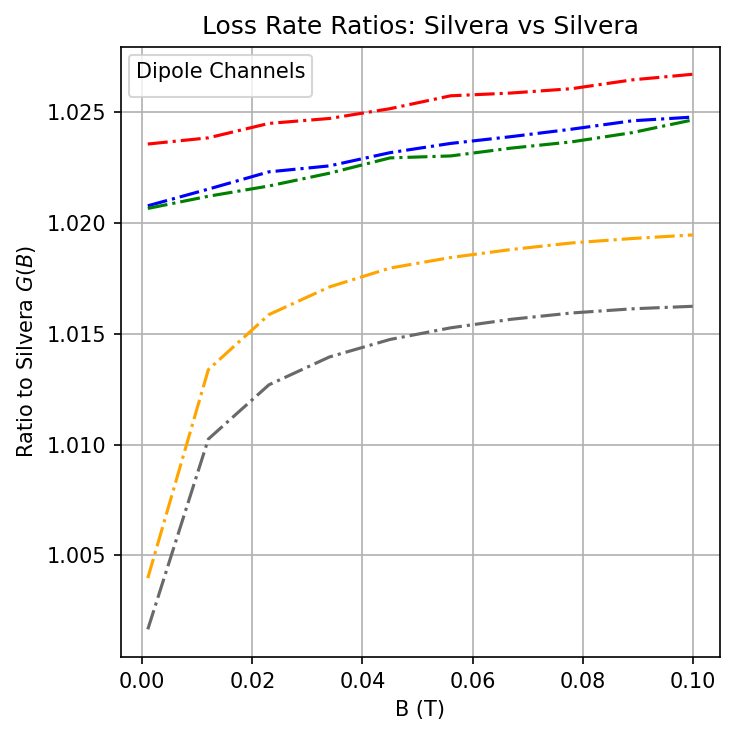


=== Jamieson / Silvera (Dipole) ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.9497, std = 0.0020
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.9537, std = 0.0024
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 0.9546, std = 0.0022
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 0.9669, std = 0.0091
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 0.9730, std = 0.0086


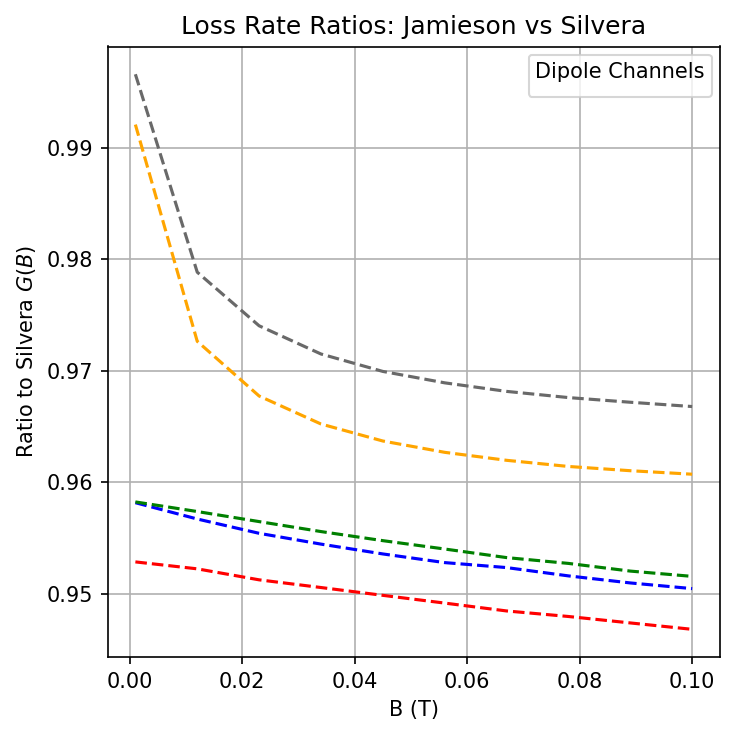

In [84]:
colors = ['red', 'blue', 'green', 'orange', 'dimgrey']
linetypes = ['-', '-.', '--', ':']

for pi, pot_key in enumerate(potentials.TripletsT.keys()):
    print(f"\n=== {pot_key} / {base_key} (Dipole) ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(DipoleChannels):
        channel_str = str(c)
        ratios = np.asarray(G_factor_ratios_adiabaticDip[pot_key][channel_str], dtype=float)
        ratios[~np.isfinite(ratios)] = np.nan 

        mean_ratio = np.nanmean(ratios)
        std_ratio  = np.nanstd(ratios)
        print(f"Channel {ci+1} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None  
        plt.plot(B_values, ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)
    plt.xlabel("B (T)")
    plt.ylabel(f"Ratio to {base_key} $G(B)$")
    plt.title(f"Loss Rate Ratios: {pot_key} vs {base_key}")
    plt.grid(True, which='both')
    plt.legend(title="Dipole Channels", fontsize=8)
    plt.tight_layout()
    plt.show()

In [81]:

entries=[]
for pi, pot_key in enumerate(potentials.Triplets.keys()):

    c=DipoleChannels[0]
    channel_str = str(c)
    ratios = np.asarray(G_factor_ratios_adiabaticDip[pot_key][channel_str], dtype=float)
    ratios[~np.isfinite(ratios)] = np.nan
    entries.append(np.nanmean(ratios))

print(f"aa->dd spread due to adiabatic correction: "f"mean = {np.max(entries):.4f}")



aa->dd spread due to adiabatic correction: mean = 1.0256


In [85]:
pots = {"Jamieson_Triplet_VDW": potentials.Jamieson_Triplet_VDW,
        "Jamieson_Triplet_HFD": potentials.Jamieson_Triplet_HFD}

G_factors_raw_two = {k: {} for k in pots.keys()}

for pot_key, pot in pots.items():
    for c in DipoleChannels:
        channel_str = str(c)
        losses = np.asarray([
            dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T, pot, 0,2,-2,rhos)
            for B in B_values], dtype=float)
        
        G_factors_raw_two[pot_key][channel_str] = losses

ratio_VDW_over_HFD = {}
for c in DipoleChannels:
    channel_str = str(c)
    num = G_factors_raw_two["Jamieson_Triplet_VDW"][channel_str]
    den = G_factors_raw_two["Jamieson_Triplet_HFD"][channel_str]
    ratio = num / den
    ratio_VDW_over_HFD[channel_str] = ratio


=== Dipole Loss Ratio: Jamieson_Triplet_VDW / Jamieson_Triplet_HFD ===
Channel 1 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0067, std = 0.0002
Channel 2 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0063, std = 0.0003
Channel 3 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}): mean = 1.0062, std = 0.0003
Channel 4 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}): mean = 1.0045, std = 0.0012
Channel 5 ({'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}): mean = 1.0037, std = 0.0012


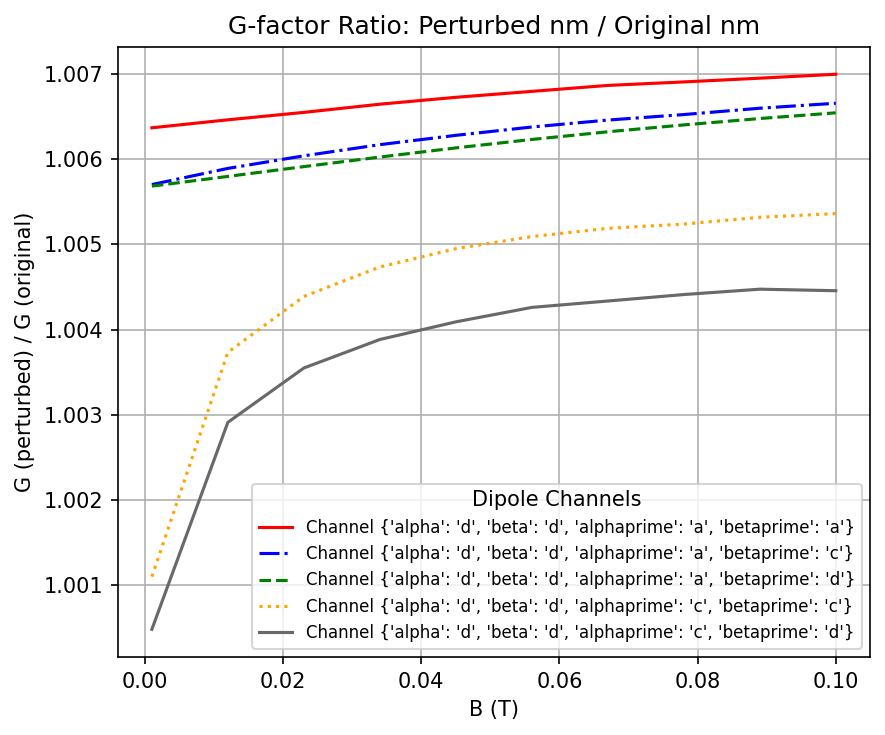

In [86]:
print("\n=== Dipole Loss Ratio: Jamieson_Triplet_VDW / Jamieson_Triplet_HFD ===")
for i, c in enumerate(DipoleChannels, start=1):
    channel_str = str(c)
    r = ratio_VDW_over_HFD[channel_str]
    mean_r = float(np.mean(r))
    std_r  = float(np.std(r))
    print(f"Channel {i} ({channel_str}): mean = {mean_r:.4f}, std = {std_r:.4f}")
    
plt.figure(figsize=(6,5), dpi=150)
for i, c in enumerate(DipoleChannels):
    channel_str = str(c)
    plt.plot(B_values,ratio_VDW_over_HFD[channel_str],
             linetypes[i % len(linetypes)],
             color=colors[i % len(colors)],
             label=f"Channel {channel_str}")

plt.xlabel("B (T)")
plt.ylabel("G (perturbed) / G (original)")
plt.title("G-factor Ratio: Perturbed nm / Original nm")
plt.grid(True, which="both")
plt.legend(title="Dipole Channels", fontsize=8)
plt.tight_layout()
plt.show()

In [95]:
entries=[]
for pi, pot_key in enumerate(potentials.Triplets.keys()):

    c=DipoleChannels[0]
    channel_str = str(c)
    ratios = np.asarray(ratio_VDW_over_HFD[channel_str], dtype=float)
    ratios[~np.isfinite(ratios)] = np.nan
    entries.append(np.nanmean(ratios))

print(f"aa->dd spread due to extrapolation: "f"mean = {np.max(entries):.4f}")

aa->dd spread due to extrapolation: mean = 1.0067


In [125]:
def get_perturbed_resultsDip(attr_name, delta):
    consts = constants.TritiumConstants()
    orig_val = getattr(consts, attr_name)
    setattr(consts, attr_name, orig_val + delta)
    results = {}
    for c in DipoleChannels:
        Gs = []
        for B in B_values:
            Gs.append(
                dipolelosses.GetGFactor(c, B, consts, T, potentials.Silvera_Triplet, 0,2,-2,rhos))
        results[str(c)] = np.array(Gs)

    return results
attr_to_perturb = "mu"                 
delta_value = amuT-constants.TritiumConstants().mu
G_perturbed = get_perturbed_resultsDip(attr_to_perturb, delta_value)

original = G_factors_rawDip["Silvera"]

Channel {'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'a'}: mean = 1.0597, std = 0.0869
Channel {'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'c'}: mean = 0.9720, std = 0.1990
Channel {'alpha': 'd', 'beta': 'd', 'alphaprime': 'a', 'betaprime': 'd'}: mean = 0.9013, std = 0.1934
Channel {'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'c'}: mean = 0.7144, std = 0.4170
Channel {'alpha': 'd', 'beta': 'd', 'alphaprime': 'c', 'betaprime': 'd'}: mean = 0.8942, std = 0.7793


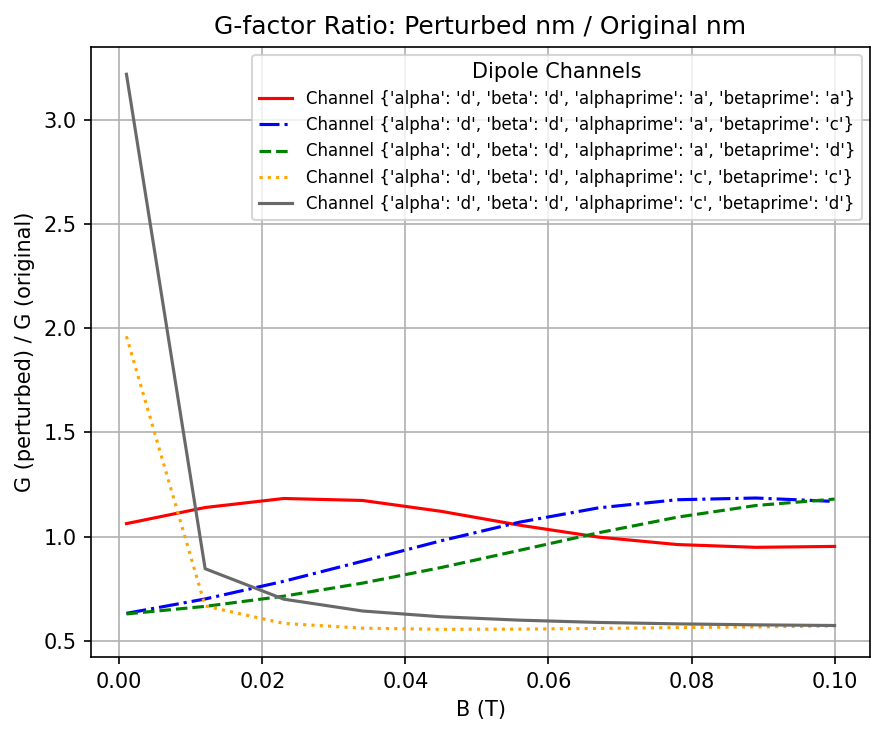

In [126]:
ratio_vs_unperturbed = {}

for channel_str in original.keys():
    unperturbed = np.asarray(original[channel_str], dtype=float)
    perturbed   = np.asarray(G_perturbed[channel_str], dtype=float)

    ratio = perturbed / unperturbed
    ratio_vs_unperturbed[channel_str] = ratio

    mean_ratio = np.nanmean(ratio)
    std_ratio  = np.nanstd(ratio)
    print(f"Channel {channel_str}: mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

plt.figure(figsize=(6, 5), dpi=150)
for i, (channel_str, ratio) in enumerate(ratio_vs_unperturbed.items()):
    plt.plot(B_values, ratio,
             label=f"Channel {channel_str}",
             linestyle=linetypes[i % len(linetypes)],
             color=colors[i % len(colors)])

plt.xlabel("B (T)")
plt.ylabel("G (perturbed) / G (original)")
plt.title("G-factor Ratio: Perturbed nm / Original nm")
plt.grid(True, which="both")
plt.legend(title="Dipole Channels", fontsize=8)
plt.tight_layout()
plt.show()


In [220]:
entries=[]
for pi, pot_key in enumerate(potentials.Triplets.keys()):

    c=DipoleChannels[0]
    channel_str = str(c)
    ratios = np.asarray(ratio_vs_unperturbed[channel_str], dtype=float)
    ratios[~np.isfinite(ratios)] = np.nan
    entries.append(np.nanmean(ratios))

print(f"aa->dd spread due to non-adiabatic correction: "f"mean = {np.max(np.abs(1-np.array(entries))):.4f}")

aa->dd spread due to non-adiabatic correction: mean = 0.0597


In [224]:
potS = potentials.Kolos_Singlet2_VDW

G_factors_raw_SETrip = {}
G_factor_ratios_SETrip = {}

base_key = "Silvera"
base_potential = potentials.Triplets[base_key]

base_losses_by_channel = {}
for c in SpinExChannels:
    channel_str = str(c)
    base_losses_by_channel[channel_str] = np.array([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, base_potential, potS, rhos)
        for B in B_values])

for pot_key, potT in potentials.Triplets.items():
    G_factors_raw_SETrip[pot_key] = {}
    G_factor_ratios_SETrip[pot_key] = {}

    for c in SpinExChannels:
        channel_str = str(c)
        losses = np.array([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, potS, rhos)
            for B in B_values])

        G_factors_raw_SETrip[pot_key][channel_str] = losses
        G_factor_ratios_SETrip[pot_key][channel_str] = losses / base_losses_by_channel[channel_str]


=== Kolos 74 / Silvera ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.9929, std = 0.0012
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.9959, std = 0.0010
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0043, std = 0.0066


/var/folders/x8/m88g9m690wb3gf4t7ds85nzw0000gn/T/ipykernel_31228/3579459060.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="SpinEx Channels", fontsize=8)


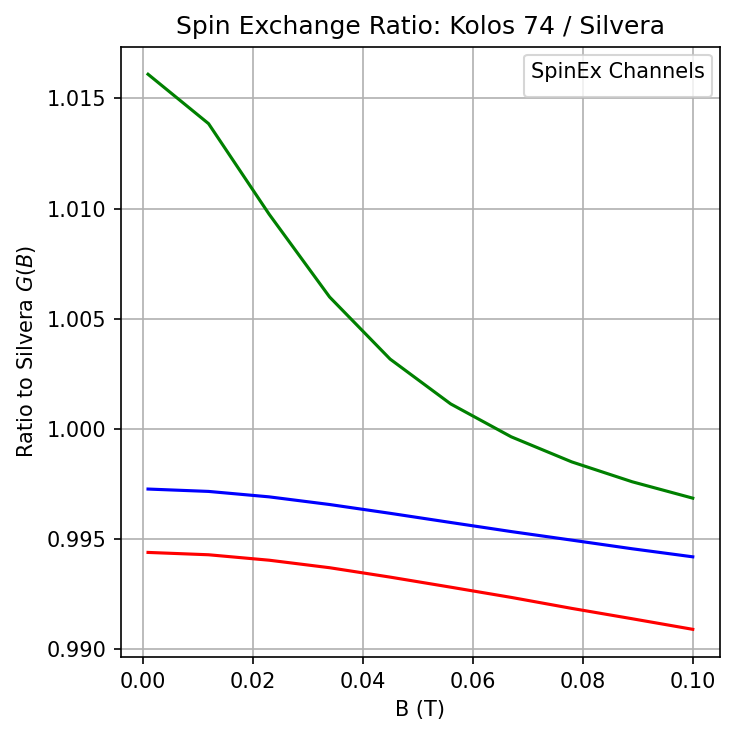


=== Silvera / Silvera ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0000, std = 0.0000
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0000, std = 0.0000
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0000, std = 0.0000


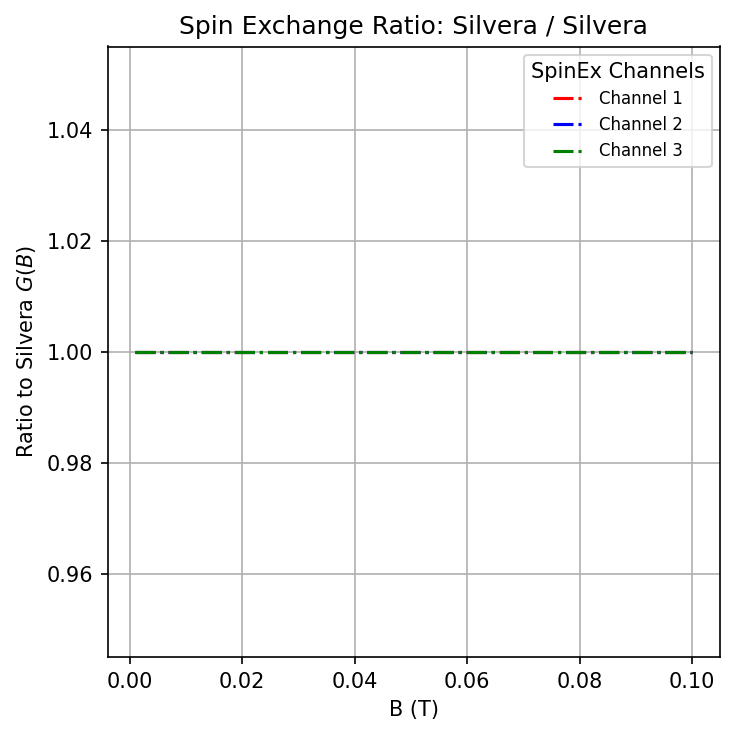


=== Jamieson / Silvera ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.9747, std = 0.0026
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.9830, std = 0.0035
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0222, std = 0.0340


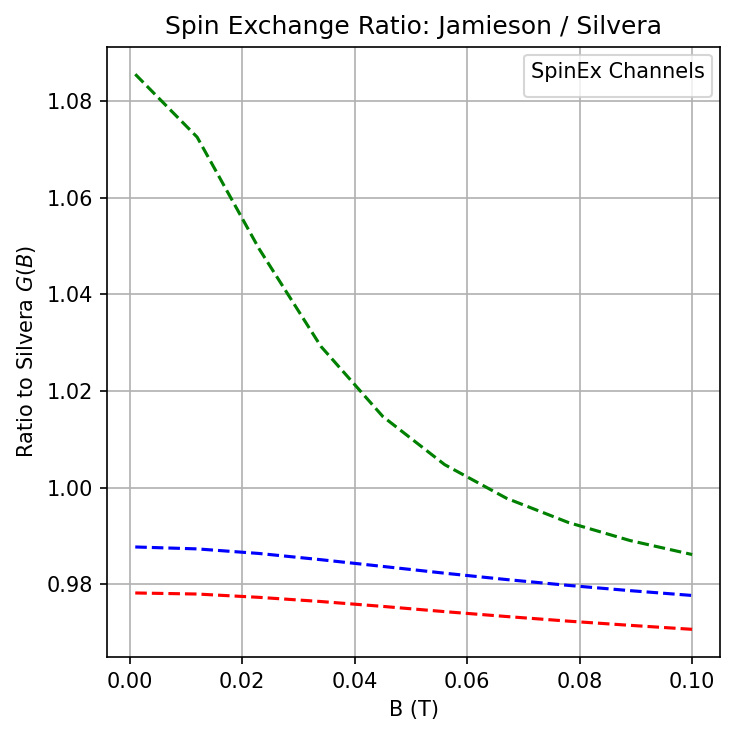

In [225]:
for pi, pot_key in enumerate(potentials.Triplets.keys()):
    print(f"\n=== {pot_key} / {base_key} ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(SpinExChannels):
        channel_str = str(c)
        ratios = np.asarray(G_factor_ratios_SETrip[pot_key][channel_str], dtype=float)
        mean_ratio = np.nanmean(ratios)
        std_ratio  = np.nanstd(ratios)
        print(f"Channel {ci+1} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")
        
        label = f"Channel {ci+1}" if pi == 1 else None  
        plt.plot(B_values,ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)

    plt.xlabel("B (T)")

    plt.ylabel(f"Ratio to {base_key} $G(B)$")
    plt.title(f"Spin Exchange Ratio: {pot_key} / {base_key}")
    plt.grid(True, which='both')
    plt.legend(title="SpinEx Channels", fontsize=8)
    plt.tight_layout()
    plt.show()

In [226]:
entries=[]
for pi, pot_key in enumerate(potentials.Triplets.keys()):

    c=SpinExChannels[0]
    channel_str = str(c)
    ratios = np.asarray(G_factor_ratios_SETrip[pot_key][channel_str], dtype=float)
    ratios[~np.isfinite(ratios)] = np.nan
    entries.append(np.nanmean(ratios))

print(f"cc->aa spread due to trip potential  "f"mean = {np.std(entries):.4f}")

cc->aa spread due to trip potential  mean = 0.0106


In [140]:
potT = potentials.Silvera_Triplet

G_factors_raw_SESing   = {}
G_factor_ratios_SESing = {}

base_key       = "Kolos 74"
base_potential = potentials.Singlets[base_key]

base_losses_by_channel = {}
for c in SpinExChannels:
    ch = str(c)
    base_losses_by_channel[ch] = np.asarray([
        spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, base_potential, rhos)
        for B in B_values
    ], dtype=float)

for pot_key, potS in potentials.Singlets.items():
    G_factors_raw_SESing[pot_key]   = {}
    G_factor_ratios_SESing[pot_key] = {}

    for c in SpinExChannels:
        ch = str(c)
        losses = np.asarray([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, potS, rhos)
                             for B in B_values], dtype=float)

        G_factors_raw_SESing[pot_key][ch]   = losses
        G_factor_ratios_SESing[pot_key][ch] = losses / base_losses_by_channel[ch]


=== Kolos 74 / Kolos 74 ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0000, std = 0.0000
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0000, std = 0.0000
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0000, std = 0.0000


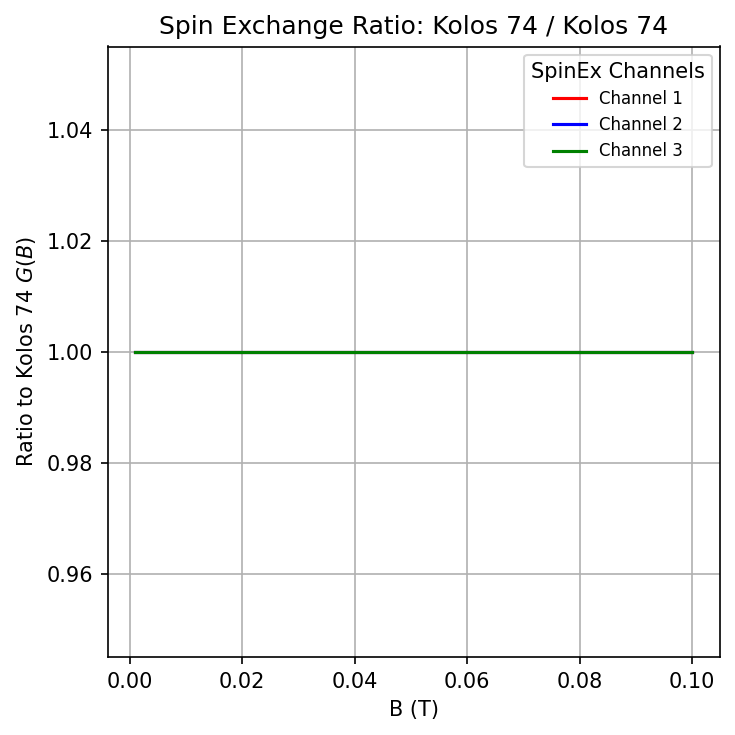


=== Wolniewicz / Kolos 74 ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.1659, std = 0.0317
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0817, std = 0.0295
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 0.9674, std = 0.0540


/var/folders/x8/m88g9m690wb3gf4t7ds85nzw0000gn/T/ipykernel_31228/915812705.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="SpinEx Channels", fontsize=8)


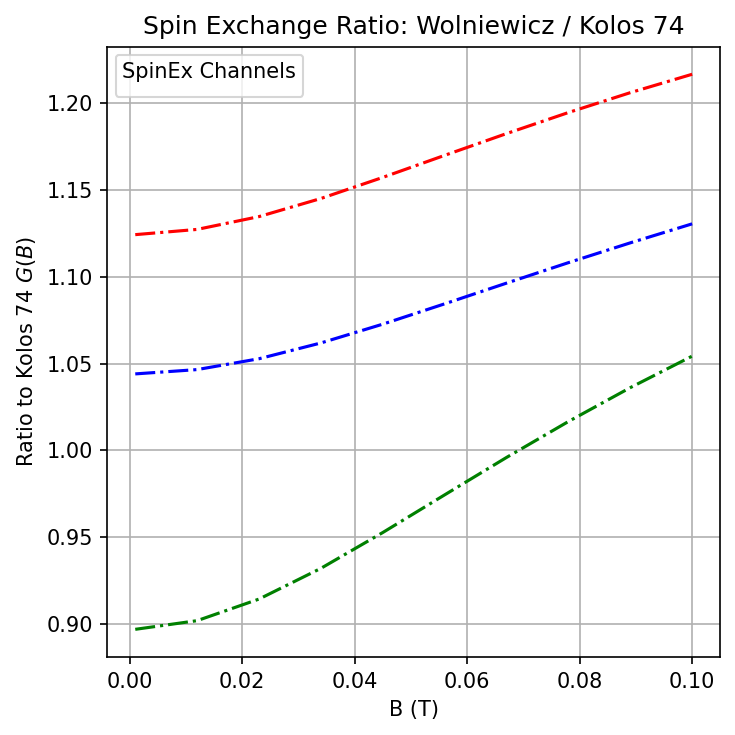


=== Jamieson / Kolos 74 ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.2947, std = 0.0658
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.1300, std = 0.0546
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 0.9375, std = 0.0858


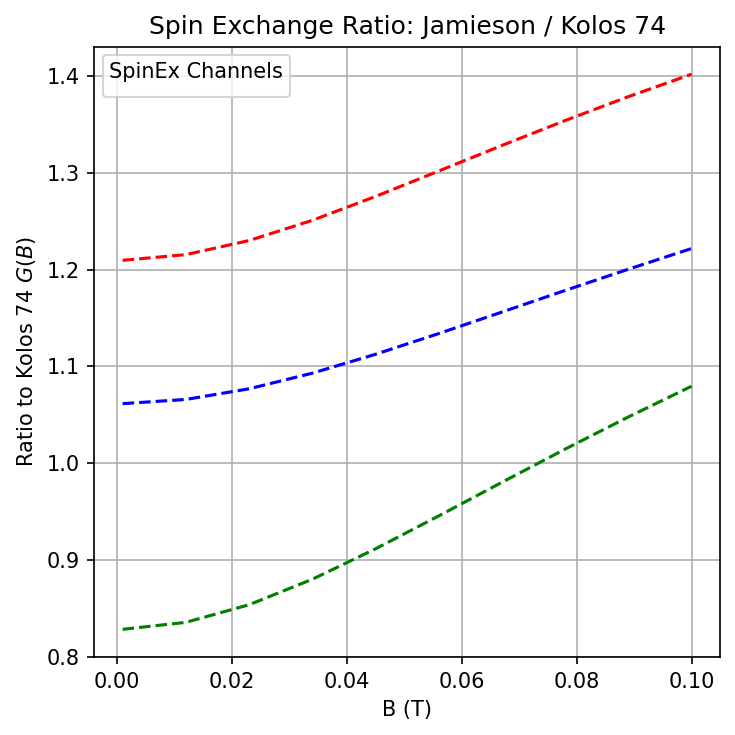

In [142]:
for pi, (pot_key, ch_map) in enumerate(G_factor_ratios_SESing.items()):
    print(f"\n=== {pot_key} / {base_key} ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(SpinExChannels):
        channel_str = str(c)
        ratios = np.asarray(ch_map[channel_str], dtype=float)

        mean_ratio = np.mean(ratios)
        std_ratio  = np.std(ratios)

        print(f"Channel {ci+1} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None
        plt.plot(
            B_values,
            ratios,
            linetypes[pi % len(linetypes)],
            color=colors[ci % len(colors)],
            label=label
        )

    plt.xlabel("B (T)")
    plt.ylabel(f"Ratio to {base_key} $G(B)$")
    plt.title(f"Spin Exchange Ratio: {pot_key} / {base_key}")
    plt.grid(True, which='both')
    plt.legend(title="SpinEx Channels", fontsize=8)
    plt.tight_layout()
    plt.show()


In [164]:
entries=[]
for pi, pot_key in enumerate(potentials.Singlets.keys()):

    c=SpinExChannels[0]
    channel_str = str(c)
    ratios = np.asarray(G_factor_ratios_SESing[pot_key][channel_str], dtype=float)
    ratios[~np.isfinite(ratios)] = np.nan
    entries.append(np.nanmean(ratios))

print(f"cc->aa spread due to poentials correction: "f"mean = {np.std(entries):.4f}")

cc->aa spread due to poentials correction: mean = 0.1206


In [154]:
label_pert = "Potential_Perturbation"
G_factors_raw_SETrip[label_pert] = {}
G_factor_ratios_SETrip[label_pert] = {}

for c in SpinExChannels:
    ch = str(c)
    pert_losses = np.array([
        spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T,
                                Potential_Perturbation, potS, rhos)
        for B in B_values
    ])
    G_factors_raw_SETrip[label_pert][ch] = pert_losses
    base_losses = base_losses_by_channel[ch]
    ratio = base_losses / pert_losses
    G_factor_ratios_SETrip[label_pert][ch] = ratio


=== Silvera / Potential_Perturbation ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.7774, std = 0.0388
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.8887, std = 0.0416
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0651, std = 0.0865


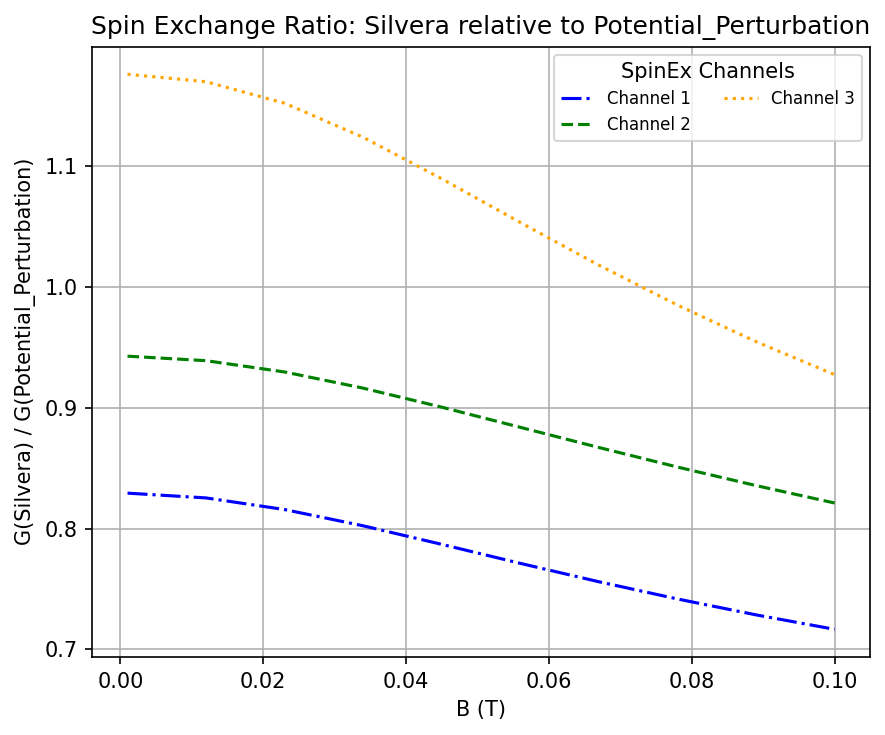

In [155]:
print(f"\n=== Silvera / {label_pert} ===")
plt.figure(figsize=(6, 5), dpi=150)

for i, c in enumerate(SpinExChannels, start=1):
    ch = str(c)

    r = np.asarray(G_factor_ratios_SETrip[label_pert][ch], dtype=float)
    r[~np.isfinite(r)] = np.nan

    mean_r = float(np.nanmean(r))
    std_r  = float(np.nanstd(r))
    print(f"Channel {i} ({ch}): mean = {mean_r:.4f}, std = {std_r:.4f}")

    plt.plot(B_values, r,
             linetypes[i % len(linetypes)],
             color=colors[i % len(colors)],
             label=f"Channel {i}")

plt.xlabel("B (T)")
plt.ylabel(f"G(Silvera) / G({label_pert})")
plt.title(f"Spin Exchange Ratio: Silvera relative to {label_pert}")
plt.grid(True, which="both")
plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [221]:
print("Triplet perturbation")
c=SpinExChannels[0]
channel_str = str(c)
print(1.-np.mean(G_factor_ratios_SETrip["Potential_Perturbation"][channel_str]))


Triplet perturbation
0.222605221522793


In [165]:
def Singlet_Perturbation(R):
    x = R * constants.hcInEVAngstrom / 4.16
    return (1 + .001*x) * potentials.Jamieson_Singlet_VDW(R)

In [166]:
potT = potentials.Silvera_Triplet
label_pert = "Singlet_Perturbation"   
singlet_pert = Singlet_Perturbation

base_key = "Jamieson"

G_factors_raw_SESing[label_pert]   = {}
G_factor_ratios_SESing[label_pert] = {}

for c in SpinExChannels:
    ch = str(c)
    losses = np.asarray([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, singlet_pert, rhos)
                         for B in B_values], dtype=float)

    G_factors_raw_SESing[label_pert][ch]   = losses
    G_factor_ratios_SESing[label_pert][ch] = losses / G_factors_raw_SESing[base_key][ch]



=== Singlet_Perturbation / Jamieson ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0330, std = 0.0088
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0112, std = 0.0071
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 0.9866, std = 0.0108


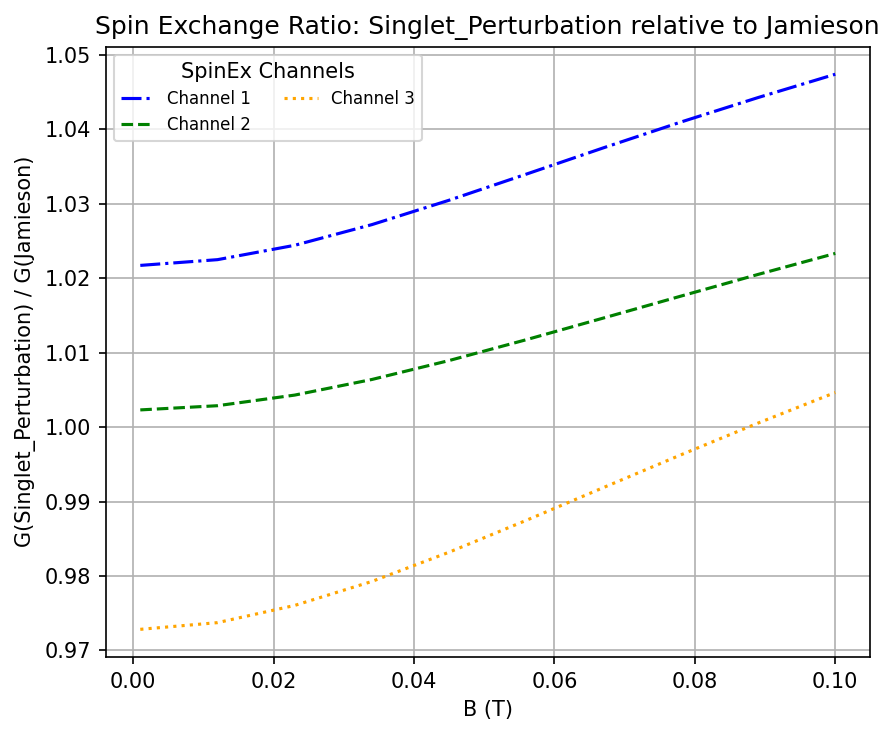

In [168]:
print(f"\n=== {label_pert} / {base_key} ===")
plt.figure(figsize=(6, 5), dpi=150)

for i, c in enumerate(SpinExChannels, start=1):
    ch = str(c)
    r = np.asarray(G_factor_ratios_SESing[label_pert][ch], dtype=float)
    r[~np.isfinite(r)] = np.nan

    mean_r = float(np.nanmean(r))
    std_r  = float(np.nanstd(r))
    print(f"Channel {i} ({ch}): mean = {mean_r:.4f}, std = {std_r:.4f}")

    plt.plot(B_values, r,
             linetypes[i % len(linetypes)],
             color=colors[i % len(colors)],
             label=f"Channel {i}")

plt.xlabel("B (T)")

plt.ylabel(f"G({label_pert}) / G({base_key})")
plt.title(f"Spin Exchange Ratio: {label_pert} relative to {base_key}")
plt.grid(True, which="both")
plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

In [222]:
print("cc->aa Triplet perturbation")
c=SpinExChannels[0]
channel_str = str(c)
print(1.-np.mean(G_factor_ratios_SESing["Singlet_Perturbation"][channel_str]))


cc->aa Triplet perturbation
-0.0330100629063792


In [172]:
def get_perturbed_resultsEx(attr_name, delta):
    consts = constants.TritiumConstants()
    orig_val = getattr(consts, attr_name)
    setattr(consts, attr_name, orig_val + delta)

    results = {}
    for c in SpinExChannels:
        Gs = []
        for B in B_values:
            Gs.append(spinexchange.GetGFactor(c, B, consts, T,
                                              potentials.Silvera_Triplet,
                                              potentials.Kolos_Singlet2_VDW,
                                              rhos))
        results[str(c)] = np.asarray(Gs, dtype=float)     
    return results

attr_to_perturb = "mu"
delta_value     = amuT-constants.TritiumConstants().mu
G_perturbedEx   = get_perturbed_resultsEx(attr_to_perturb, delta_value)


Channel {'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}: mean = 0.9600, std = 0.0059
Channel {'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}: mean = 0.9773, std = 0.0066
Channel {'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}: mean = 1.0069, std = 0.0151


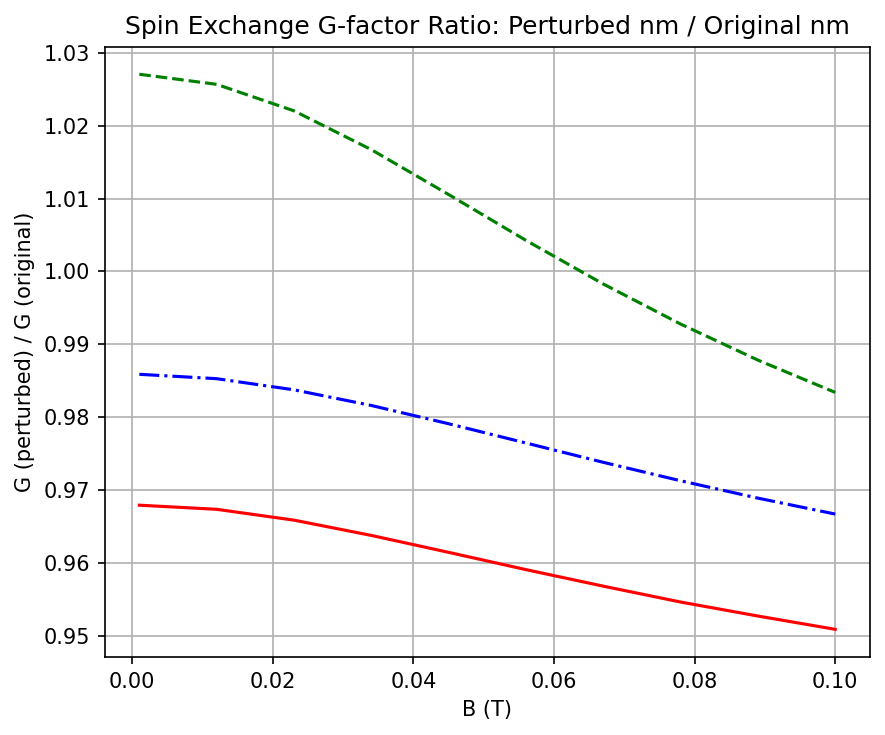

In [176]:
ratio_vs_unperturbedEx = {}

originalEx = G_factors_raw_SESing["Kolos 74"]   
for ch in originalEx.keys():
    unperturbed = np.asarray(originalEx[ch], dtype=float)
    perturbed   = np.asarray(G_perturbedEx[ch], dtype=float)
    ratio       = perturbed / unperturbed
    ratio_vs_unperturbedEx[ch] = ratio

    mean_ratio = float(np.nanmean(ratio))
    std_ratio  = float(np.nanstd(ratio))
    print(f"Channel {ch}: mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

plt.figure(figsize=(6, 5), dpi=150)
for i, (ch, ratio) in enumerate(ratio_vs_unperturbedEx.items()):
    plt.plot(B_values, ratio,
             label=f"Channel {ch}",
             linestyle=linetypes[i % len(linetypes)],
             color=colors[i % len(colors)])

plt.xlabel("B (T)")
plt.ylabel("G (perturbed) / G (original)")
plt.title("Spin Exchange G-factor Ratio: Perturbed nm / Original nm")
plt.grid(True, which="both")
#plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [193]:

c=SpinExChannels[0]
channel_str = str(c)
ratios = np.asarray(ratio_vs_unperturbedEx[channel_str], dtype=float)
ratios[~np.isfinite(ratios)] = np.nan


print(f"cc->aa spread due to non-adiabatic correction: "f"mean = {1-np.mean(ratios):.4f}")

cc->aa spread due to non-adiabatic correction: mean = 0.0400


In [194]:
potS = potentials.Kolos_Singlet2_VDW

G_factors_raw_adiabaticTrip = {}
G_factor_ratios_adiabaticTrip = {}

for pot_key, potT in potentials.TripletsT.items():
    G_factors_raw_adiabaticTrip[pot_key] = {}
    G_factor_ratios_adiabaticTrip[pot_key] = {}

    for c in SpinExChannels:
        channel_str = str(c)
        losses = np.array([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, potS, rhos)
            for B in B_values])

        G_factors_raw_adiabaticTrip[pot_key][channel_str] = losses
        G_factor_ratios_adiabaticTrip[pot_key][channel_str] = losses / G_factors_raw_SETrip[pot_key][channel_str]

In [203]:

entries=[]
for pi, pot_key in enumerate(potentials.Triplets.keys()):

    c=SpinExChannels[0]
    channel_str = str(c)
    ratios = np.asarray(G_factor_ratios_adiabaticTrip[pot_key][channel_str], dtype=float)
    ratios[~np.isfinite(ratios)] = np.nan
    entries.append(np.nanmean(ratios))

print(f"aa->dd spread due to adiabatic correction: "f"mean = {np.max(np.abs(1-np.array(entries))):.4f}")

aa->dd spread due to adiabatic correction: mean = 0.0128



=== Kolos 74 (adiabatic / non-adiabatic) ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.9937, std = 0.0005
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.9956, std = 0.0009
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0060, std = 0.0090


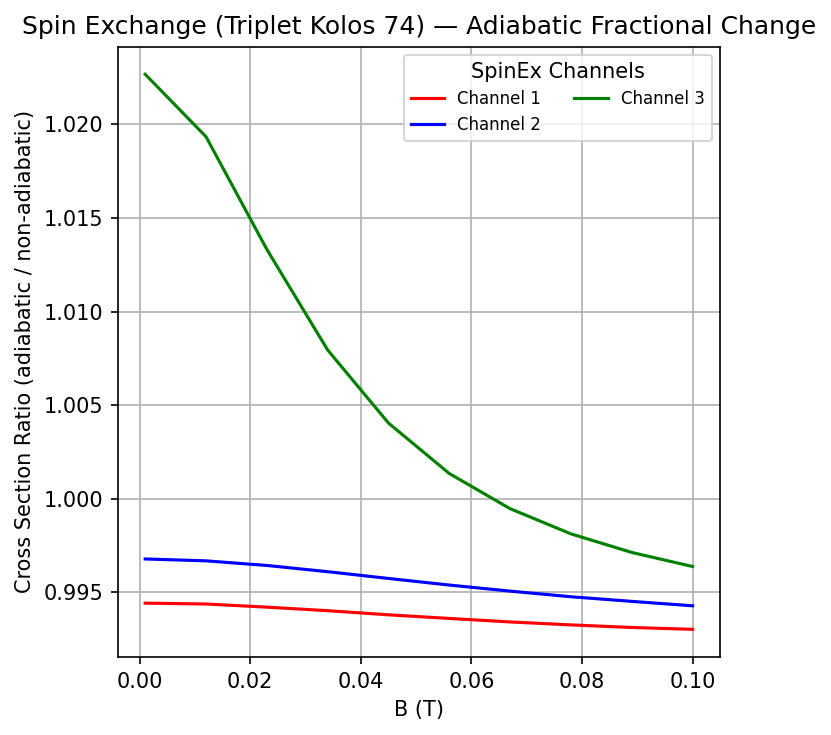


=== Silvera (adiabatic / non-adiabatic) ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.9938, std = 0.0005
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.9957, std = 0.0009
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0060, std = 0.0089


/var/folders/x8/m88g9m690wb3gf4t7ds85nzw0000gn/T/ipykernel_31228/1044899120.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)


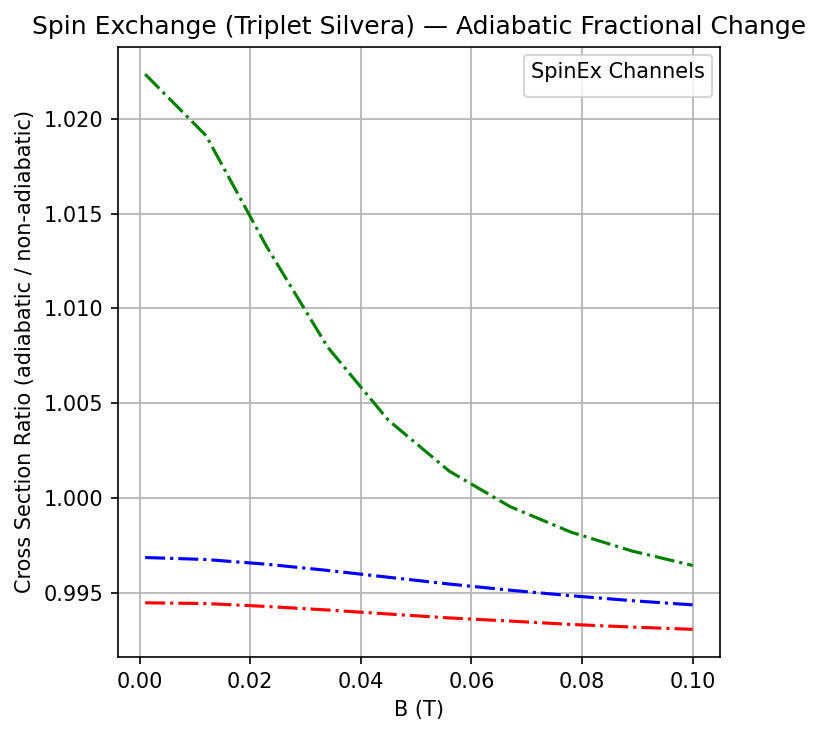


=== Jamieson (adiabatic / non-adiabatic) ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0128, std = 0.0010
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0091, std = 0.0017
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 0.9884, std = 0.0180


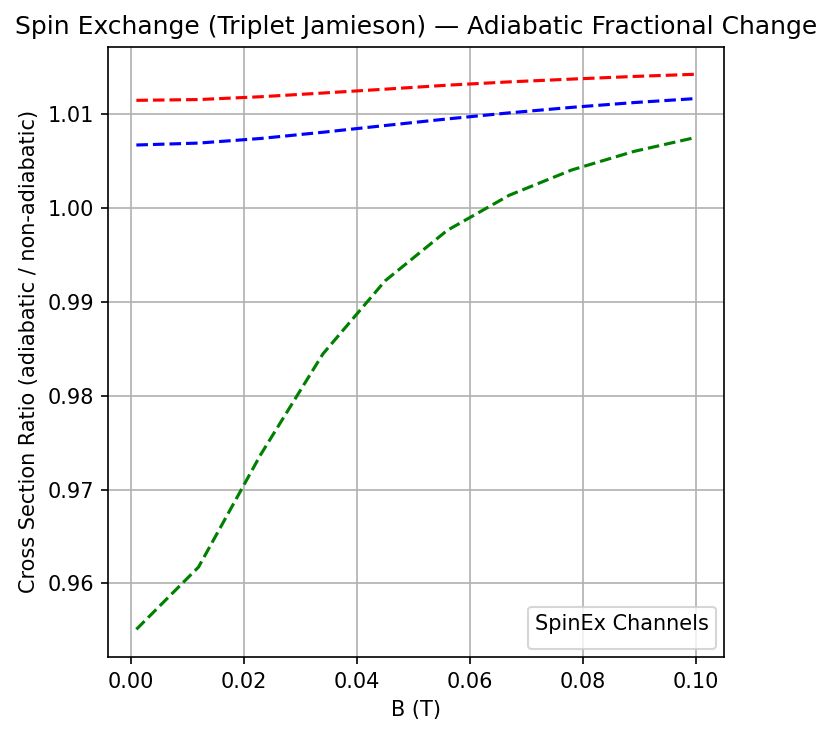

In [204]:
for pi, pot_key in enumerate(G_factor_ratios_adiabaticTrip.keys()):
    print(f"\n=== {pot_key} (adiabatic / non-adiabatic) ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(SpinExChannels):
        channel_str = str(c)

        ratios = np.asarray(G_factor_ratios_adiabaticTrip[pot_key][channel_str], dtype=float)
        ratios[~np.isfinite(ratios)] = np.nan  
        mean_ratio = float(np.nanmean(ratios))
        std_ratio  = float(np.nanstd(ratios))
        print(f"Channel {ci+1} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None
        plt.plot(B_values,ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)

    plt.xlabel("B (T)")
    plt.ylabel("Cross Section Ratio (adiabatic / non-adiabatic)")
    plt.title(f"Spin Exchange (Triplet {pot_key}) — Adiabatic Fractional Change")
    plt.grid(True, which='both')
    plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()


In [188]:
potT = potentials.Silvera_Triplet

G_factors_raw_adiabaticSing   = {}
G_factor_ratios_adiabaticSing = {}

for pot_key, potS in potentials.SingletsT.items():
    G_factors_raw_adiabaticSing[pot_key]   = {}
    G_factor_ratios_adiabaticSing[pot_key] = {}

    for c in SpinExChannels:
        ch = str(c)
        losses = np.asarray([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, potS, rhos)
                             for B in B_values], dtype=float)

        G_factors_raw_adiabaticSing[pot_key][ch]   = losses
        G_factor_ratios_adiabaticSing[pot_key][ch] = losses / G_factors_raw_SESing[pot_key][ch]


=== Kolos 74 (adiabatic / non-adiabatic, Singlet) ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.9603, std = 0.0057
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.9772, std = 0.0065
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0072, std = 0.0158


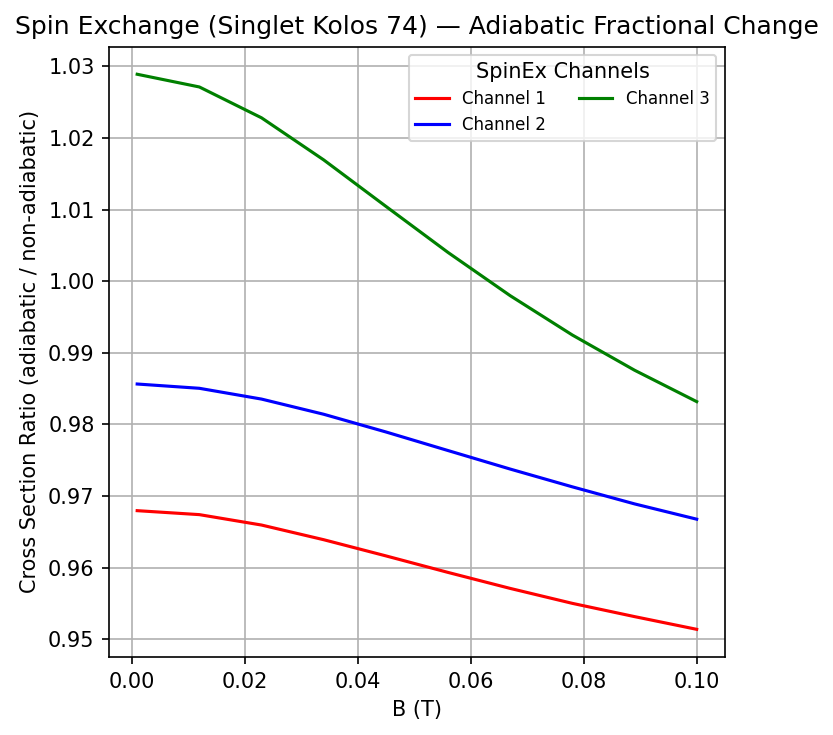


=== Wolniewicz (adiabatic / non-adiabatic, Singlet) ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0510, std = 0.0110
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0221, std = 0.0099
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 0.9852, std = 0.0170


/var/folders/x8/m88g9m690wb3gf4t7ds85nzw0000gn/T/ipykernel_31228/3929854623.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)


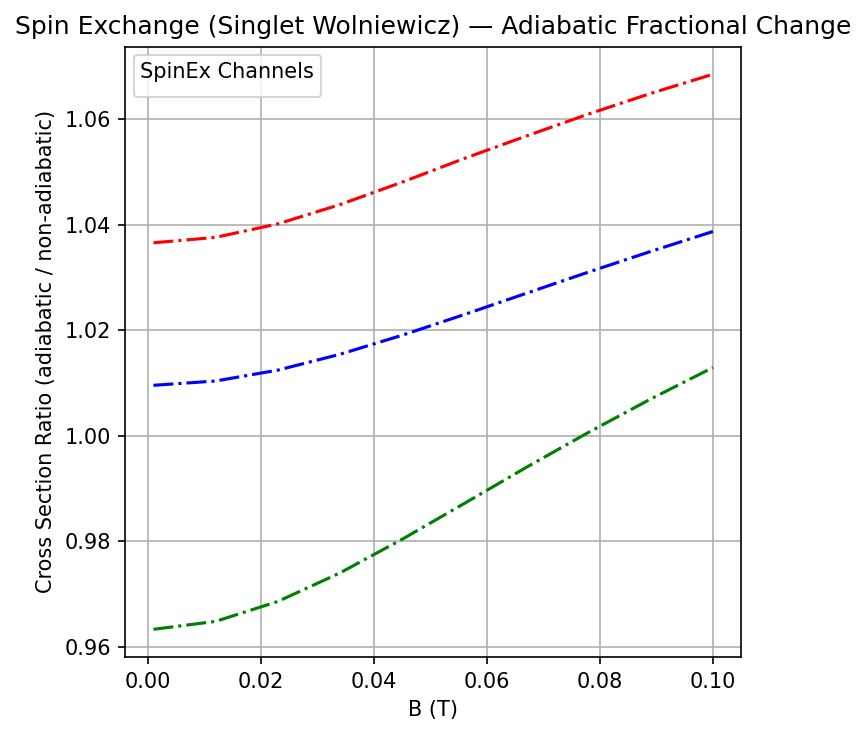


=== Jamieson (adiabatic / non-adiabatic, Singlet) ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 1.0346, std = 0.0092
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 1.0118, std = 0.0075
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 0.9859, std = 0.0113


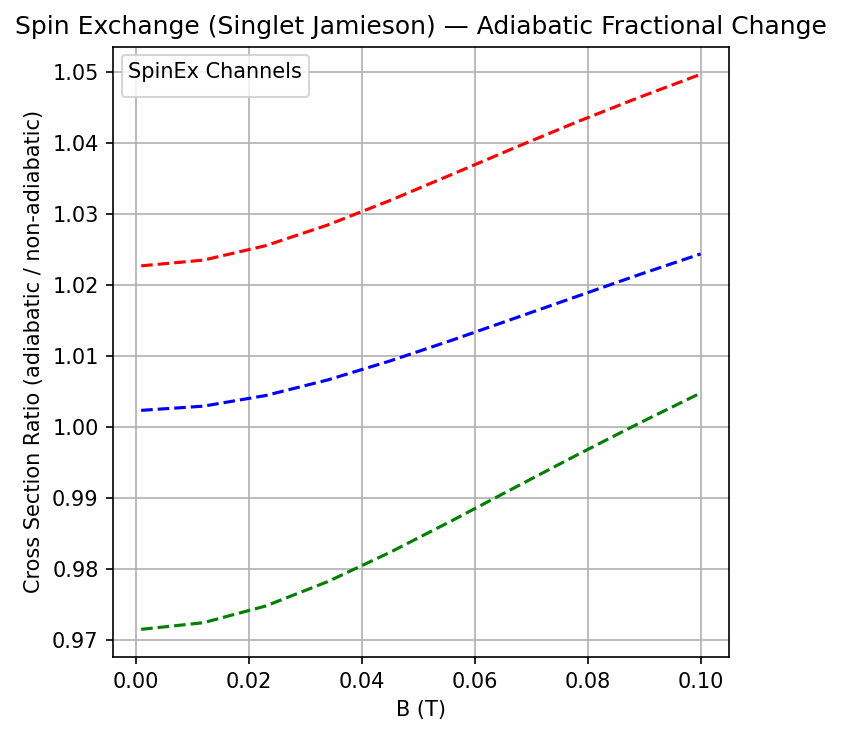

In [207]:
for pi, pot_key in enumerate(G_factor_ratios_adiabaticSing.keys()):
    print(f"\n=== {pot_key} (adiabatic / non-adiabatic, Singlet) ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(SpinExChannels):
        ch = str(c)
        ratios = np.asarray(G_factor_ratios_adiabaticSing[pot_key][ch], dtype=float)
        ratios[~np.isfinite(ratios)] = np.nan  

        mean_ratio = float(np.nanmean(ratios))
        std_ratio  = float(np.nanstd(ratios))
        print(f"Channel {ci+1} ({ch}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None
        plt.plot(B_values, ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)

    plt.xlabel("B (T)")
    plt.ylabel("Cross Section Ratio (adiabatic / non-adiabatic)")
    plt.title(f"Spin Exchange (Singlet {pot_key}) — Adiabatic Fractional Change")
    plt.grid(True, which='both')
    plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()


In [214]:
potS = potentials.Kolos_Singlet2_VDW

G_factors_raw_trip_extrap   = {}
G_factor_ratios_trip_extrap = {}

num_key = "Jamieson_Triplet_VDW"
den_key = "Jamieson"
G_factors_raw_trip_extrap[num_key] = {}
for c in SpinExChannels:
    ch = str(c)
    vals = [spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T,
                                    potentials.Jamieson_Triplet_VDW, potS, rhos)
            for B in B_values]
    G_factors_raw_trip_extrap[num_key][ch] = np.asarray(vals, dtype=float)

G_factor_ratios_trip_extrap["VDW"] = {}
for c in SpinExChannels:
    ch = str(c)
    num = np.asarray(G_factors_raw_trip_extrap[num_key][ch], dtype=float)
    den = np.asarray(G_factors_raw_SETrip[den_key][ch], dtype=float)  
    ratio = num / den
    G_factor_ratios_trip_extrap["VDW"][ch] = ratio


=== Jamieson_Triplet_VDW / Jamieson (Spin-exchange) ===
Channel 1 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'a'}): mean = 0.9991, std = 0.0001
Channel 2 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'a', 'betaprime': 'c'}): mean = 0.9992, std = 0.0001
Channel 3 ({'alpha': 'c', 'beta': 'c', 'alphaprime': 'b', 'betaprime': 'd'}): mean = 1.0016, std = 0.0024


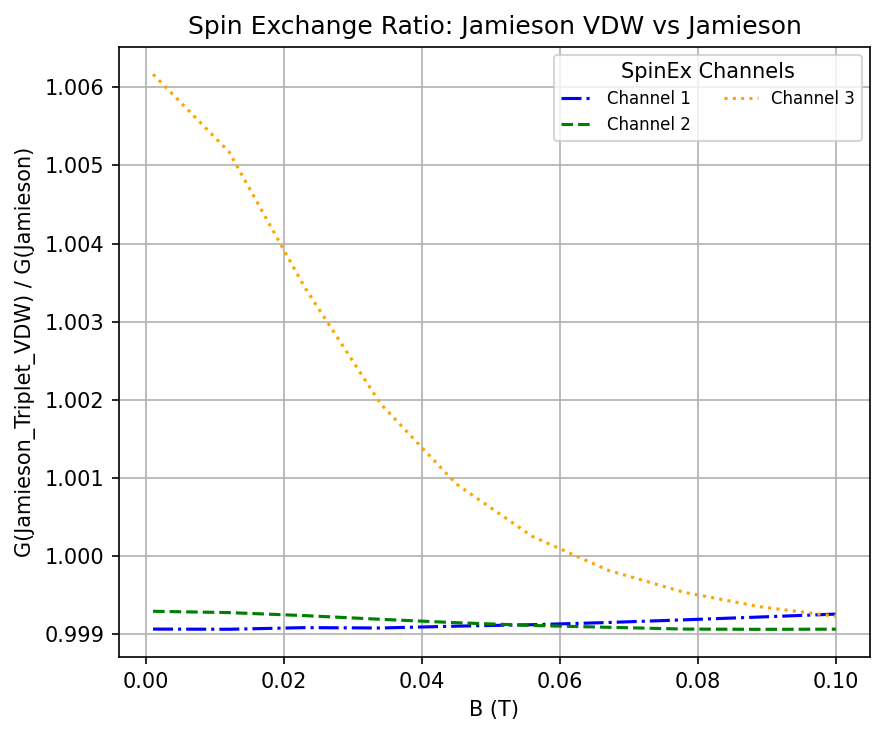

In [210]:
print("\n=== Jamieson_Triplet_VDW / Jamieson (Spin-exchange) ===")
plt.figure(figsize=(6,5), dpi=150)
for i, c in enumerate(SpinExChannels, start=1):
    ch = str(c)
    r = np.asarray(G_factor_ratios_trip_extrap["VDW"][ch], dtype=float)
    r[~np.isfinite(r)] = np.nan

    mean_r = float(np.nanmean(r))
    std_r  = float(np.nanstd(r))
    print(f"Channel {i} ({ch}): mean = {mean_r:.4f}, std = {std_r:.4f}")

    plt.plot(B_values, r,
             linetypes[i % len(linetypes)],
             color=colors[i % len(colors)],
             label=f"Channel {i}")

plt.xlabel("B (T)")
plt.ylabel("G(Jamieson_Triplet_VDW) / G(Jamieson)")
plt.title("Spin Exchange Ratio: Jamieson VDW vs Jamieson")
plt.grid(True, which='both')
plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

In [223]:
entries=[]

c=SpinExChannels[0]
channel_str = str(c)
ratios = np.asarray(G_factor_ratios_trip_extrap["VDW"][channel_str], dtype=float)
ratios[~np.isfinite(ratios)] = np.nan
entries.append(np.nanmean(ratios))

print(f"aa->dd spread due to extrapolation: "f"mean = {np.max(np.abs(1-np.array(entries))):.5f}")

aa->dd spread due to extrapolation: mean = 0.00087
